# 04 - Nodes distance matrix

This notebook loads all previously downloaded nodes and edges from notebook 02 and creates a __matrix containing the distance traveling by edges from each node to all nodes.__ However, __the processing was not made from each node to each other node, but rather using the hexgrid to create a smaller matrix:__

1. Nodes and the hexgrid are loaded
2. All hexs with nodes inside them are identified. __[A table containing all nodes and their hex is created]__
3. The centroid of those hexs is extracted and assigned to their nearest node. __[The table is updated, now it contains all nodes and the nearest node to the hexs centroid (col 'representative_node')]__
5. These nodes become the sole points of interest to which all nodes travel to.

## __Import libraries__

In [1]:
from pathlib import Path

current_path = Path().resolve()

for parent in current_path.parents:
    if parent.name == "accesibilidad-urbana":
        project_root = parent
        break

print(project_root)

/home/observatorio/Documents/repos/accesibilidad-urbana


In [2]:
import os
import sys

import pandas as pd
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

from tqdm import tqdm

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join(project_root))
if module_path not in sys.path:
    print(f"Path found.")
    sys.path.append(module_path)
    import aup
else:
    print(f"Path already loaded.")
    import aup

repo_path = str(module_path)+"/"
print(f"Repo path: {repo_path}")

Path already loaded.
Repo path: /home/observatorio/Documents/repos/accesibilidad-urbana/


## __Notebook config__

In [10]:
# ----- ----- ----- Input configuration
project_path = repo_path + "data/projects/30_taojuan/"

# ----- ----- ----- Process configuration
projected_crs = "EPSG:32651"
hex_res = 11
project_schema = 'projects_research'
aoi_table = 'taoyuan_aoi'
nodes_table = 'taoyuan_nodes_drawnaoi'
edges_table = 'taoyuan_edges_drawnaoi'
hex_table = 'taoyuan_hexgrid'

# ----- ----- ----- Saving configuration
# save output to database?
save = True
if_exists='replace'

## __Load nodes and hexgrid__

#### Load nodes

In [4]:
query = f"SELECT * FROM {project_schema}.{nodes_table}"
nodes_gdf = aup.gdf_from_query(query, geometry_col='geometry')
if nodes_gdf.crs != "EPSG:4326":
    nodes_gdf = nodes_gdf.to_crs("EPSG:4326")

# Show
print(nodes_gdf.crs)
print(nodes_gdf.shape)
nodes_gdf.head(2)

EPSG:4326
(245235, 5)


,osmid,x,y,street_count,geometry
0,25423153,121.421453,25.065326,3,POINT (121.42145 25.06533)
1,25423160,121.439500,25.069168,3,POINT (121.4395 25.06917)


#### Load hexgrid

In [5]:
query = f"SELECT * FROM {project_schema}.{hex_table} WHERE \"res\"={hex_res}"
hex_gdf = aup.gdf_from_query(query, geometry_col='geometry')
if hex_gdf.crs != "EPSG:4326":
    hex_gdf = hex_gdf.to_crs("EPSG:4326")
    
# Show
print(hex_gdf.crs)
print(hex_gdf.shape)
hex_gdf.head(1)

EPSG:4326
(1037498, 4)


,hex_id,res,aoi_name,geometry
0,8b4ba56961b3fff,11,taoyuan_drawn_aoi,"POLYGON ((121.50602 25.1279, 121.50607 25.1276..."


## __Identify hexs containing nodes__

### --- Creating "nodes_hex", relation between each node and the hex it falls in ---

In [6]:
nodes_hex = gpd.sjoin(nodes_gdf[['osmid','geometry']], hex_gdf[['hex_id','geometry']], how='left')
nodes_hex.drop(columns=['index_right'],inplace=True)

# Show
print(f"All nodes fall in {len(nodes_hex.hex_id.unique())} hexs.")
print(nodes_hex.crs)
print(nodes_hex.shape)
nodes_hex.head(5)

All nodes fall in 148543 hexs.
EPSG:4326
(245235, 3)


,osmid,geometry,hex_id
0,25423153,POINT (121.42145 25.06533),8b4ba0b5a431fff
1,25423160,POINT (121.4395 25.06917),8b4ba0b5a2c8fff
2,25423587,POINT (121.53571 25.06579),8b4ba0a6ad91fff
3,25423605,POINT (121.54914 25.04494),8b4ba0a412f4fff
4,25423609,POINT (121.54899 25.0281),8b4ba0a4e50bfff


In [7]:
hexs_with_nodes = hex_gdf.loc[hex_gdf.hex_id.isin(list(nodes_hex.hex_id.unique()))].copy()

# Show
print(hexs_with_nodes.crs)
print(hexs_with_nodes.shape)
hexs_with_nodes.head(5)

EPSG:4326
(148542, 4)


,hex_id,res,aoi_name,geometry
0,8b4ba56961b3fff,11,taoyuan_drawn_aoi,"POLYGON ((121.50602 25.1279, 121.50607 25.1276..."
7,8b4ba0bb4376fff,11,taoyuan_drawn_aoi,"POLYGON ((121.13491 24.97773, 121.13496 24.977..."
10,8b4ba0a0c212fff,11,taoyuan_drawn_aoi,"POLYGON ((121.41211 25.01027, 121.41216 25.010..."
15,8b4ba0a414f0fff,11,taoyuan_drawn_aoi,"POLYGON ((121.53535 25.03859, 121.5354 25.0383..."
18,8b4ba0a5816cfff,11,taoyuan_drawn_aoi,"POLYGON ((121.54114 24.99727, 121.54119 24.997..."


## __Extract those hex's centroids__

In [8]:
# Extract representative points
hex_representative_points = gpd.GeoDataFrame(geometry=hexs_with_nodes.representative_point())

# Add hex data back to representative points
centroid_hex_id = hex_representative_points.merge(hexs_with_nodes[['hex_id','geometry']], right_index=True, left_index=True) 
# Format geometry column and create GeoDataFrame
centroid_hex_id.drop(columns=['geometry_y'], inplace=True)
centroid_hex_id.rename(columns={'geometry_x':'geometry'}, inplace=True)
centroid_hex_id = gpd.GeoDataFrame(centroid_hex_id, geometry='geometry')

# Show
print(centroid_hex_id.crs)
print(centroid_hex_id.shape)
centroid_hex_id.head(5)

EPSG:4326
(148542, 2)


,geometry,hex_id
0,POINT (121.50627 25.12784),8b4ba56961b3fff
7,POINT (121.13516 24.97768),8b4ba0bb4376fff
10,POINT (121.41237 25.01021),8b4ba0a0c212fff
15,POINT (121.53561 25.03854),8b4ba0a414f0fff
18,POINT (121.54139 24.99721),8b4ba0a5816cfff


## __Assign hex's centroids to their nearest node__

#### Load area of interest

In [11]:
aoi_name = 'taoyuan_drawn_aoi'

# Load area of interest
query = f"SELECT * FROM {project_schema}.{aoi_table} WHERE \"aoi_name\" LIKE \'{aoi_name}\'"
aoi_gdf = aup.gdf_from_query(query, geometry_col='geometry')
aoi_gdf = aoi_gdf.set_crs("EPSG:4326")

# Create buffer
aoi_buffer = aoi_gdf.to_crs(projected_crs).buffer(500)

# Turn into GeoDataFrame
aoi_buffer_gdf = gpd.GeoDataFrame(aoi_buffer)
aoi_buffer_gdf.rename(columns={0:'geometry'},inplace=True)
aoi_buffer_gdf= aoi_buffer_gdf.set_geometry('geometry',crs=projected_crs)

# Change back crs
aoi_buffer_gdf = aoi_buffer_gdf.to_crs("EPSG:4326")

# Show
print(aoi_buffer_gdf.crs)
print(aoi_buffer_gdf.shape)
aoi_buffer_gdf.head(1)

EPSG:4326
(1, 1)


,geometry
0,"POLYGON ((120.98197 24.93536, 120.98184 24.935..."


#### Create G

In [12]:
G, _n, _e = aup.graph_from_hippo(aoi_buffer_gdf, schema=project_schema, edges_folder=edges_table, nodes_folder=nodes_table)

#### Find nearest

In [13]:
nodes_nearest = nodes_gdf.set_index('osmid')
nearest = aup.find_nearest(G, nodes_nearest, gdf=centroid_hex_id, return_distance=True)
del nodes_nearest

# Show
print(nearest.crs)
print(nearest.shape)
nearest.head(1)

EPSG:4326
(148542, 4)


,geometry,hex_id,osmid,distance_node
0,POINT (121.50627 25.12784),8b4ba56961b3fff,3703938789,2.315291


#### NOTE: Found that some 183/148542 __hexs are assigned to the same nearest node.__ This is due to the polygon being e hexagon. Nodes near the hex edges are closer than nodes near their vertexes --> The nearest node to a hexs centroid could be outside that hex (near one of its edges), even when there are other nodes inside that hex (near one of its vertex)

In [30]:
nearest.loc[nearest.duplicated(subset='osmid')]

,geometry,hex_id,osmid,distance_node
95114,POINT (121.56125 25.07408),8b4ba0a6bc20fff,3769013507,24.780123
102143,POINT (121.33672 25.08009),8b4ba0b0b2a4fff,10700939955,24.506195
118400,POINT (121.14295 24.9384),8b4ba0bb228cfff,7190840806,24.236120
118550,POINT (121.7768 25.13849),8b4ba1d7540efff,11499616233,23.165077
144147,POINT (121.30146 24.99851),8b4ba0a30728fff,2168507950,21.912604
...,...,...,...,...
1025120,POINT (121.18404 24.89868),8b4ba0b933a2fff,4421217428,24.786672
1028366,POINT (121.26723 24.90322),8b4ba0aa6312fff,4395241973,22.634413
1031621,POINT (121.63304 25.06411),8b4ba1d33622fff,12094643144,22.392683
1033864,POINT (121.41803 25.00876),8b4ba0a0896cfff,1993315024,23.481390


In [31]:
nearest.loc[nearest.osmid==3769013507]

,geometry,hex_id,osmid,distance_node
70686,POINT (121.56078 25.07396),8b4ba0a6bc26fff,3769013507,24.280329
95114,POINT (121.56125 25.07408),8b4ba0a6bc20fff,3769013507,24.780123


In [17]:
nodes.reset_index(inplace=True)

<Axes: >

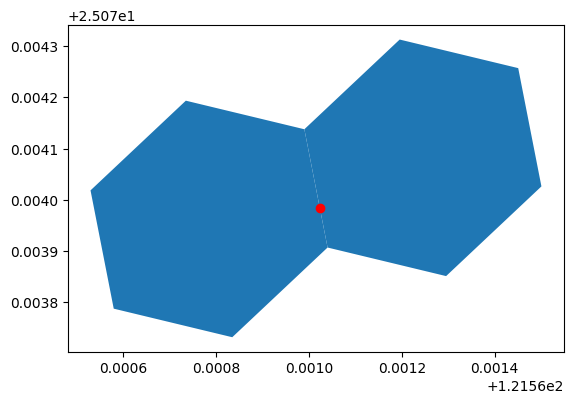

In [32]:
fig,ax = plt.subplots()

hex_ids = ['8b4ba0a6bc26fff','8b4ba0a6bc20fff']
hexs_test = hex_gdf.loc[hex_gdf.hex_id.isin(hex_ids)].copy()

osmids = 3769013507
nodes_test = nodes_gdf.loc[nodes_gdf.osmid==osmids].copy()

# Plot
nodes_test.plot(zorder=1,color='red',ax=ax)
hexs_test.plot(zorder=0,ax=ax)

### --- Retrieve "nodes_hex", and create relation between each node and the nearest osmid (poi) it was assigned to ---

In [14]:
# Merge nodes_hex with nearest on hex_id
nodes_repnode = nodes_hex.merge(nearest[['hex_id','osmid']], on='hex_id',how='left')
# Rename osmid cols. _x is original node's osmid, _y is nearest osmid (representative osmid)
nodes_repnode.rename(columns={'osmid_x':'osmid',
                              'osmid_y':'representative_osmid'},inplace=True)

# Show
print(nodes_repnode.crs)
print(nodes_repnode.shape)
nodes_repnode.head(2)

EPSG:4326
(245235, 4)


,osmid,geometry,hex_id,representative_osmid
0,25423153,POINT (121.42145 25.06533),8b4ba0b5a431fff,25423153.0
1,25423160,POINT (121.4395 25.06917),8b4ba0b5a2c8fff,25423160.0


## __Create and save nodes distance matrix__

#### Retrieve nodes

In [15]:
# Show
print(nodes_gdf.crs)
print(nodes_gdf.shape)
nodes_gdf.head(2)

EPSG:4326
(245235, 5)


,osmid,x,y,street_count,geometry
0,25423153,121.421453,25.065326,3,POINT (121.42145 25.06533)
1,25423160,121.439500,25.069168,3,POINT (121.4395 25.06917)


#### Load edges

In [16]:
query = f"SELECT * FROM {project_schema}.{edges_table}"
edges_gdf = aup.gdf_from_query(query, geometry_col='geometry')
if edges_gdf.crs != "EPSG:4326":
    edges_gdf = edges_gdf.to_crs("EPSG:4326")

# Show
print(edges_gdf.crs)
print(edges_gdf.shape)
edges_gdf.head(2)

EPSG:4326
(638183, 18)


,u,v,key,osmid,oneway,lanes,name,highway,maxspeed,length,geometry,bridge,ref,junction,tunnel,access,width,service
0,4421143392,4397397103,0,285666853,False,None,湖山街,unclassified,None,30.375803,"LINESTRING (121.35037 24.98395, 121.35041 24.9...",None,None,None,None,None,None,None
1,4421143392,2893294431,0,285666853,False,None,湖山街,unclassified,None,71.379208,"LINESTRING (121.35037 24.98395, 121.35027 24.9...",None,None,None,None,None,None,None


#### Clean nearest (points of interest)

In [17]:
nearest_nodups = nearest.drop_duplicates(subset=['osmid'])

# Show
print(nearest_nodups.crs)
print(nearest_nodups.shape)
nearest_nodups.head(2)

EPSG:4326
(148359, 4)


,geometry,hex_id,osmid,distance_node
0,POINT (121.50627 25.12784),8b4ba56961b3fff,3703938789,2.315291
7,POINT (121.13516 24.97768),8b4ba0bb4376fff,11419728221,21.276840


#### Iterate over points of interest (nearest_nodups) to analyze time to each representative node

In [19]:
nearest_nodups.head(2)

,geometry,hex_id,osmid,distance_node
0,POINT (121.50627 25.12784),8b4ba56961b3fff,3703938789,2.315291
7,POINT (121.13516 24.97768),8b4ba0bb4376fff,11419728221,21.276840


In [ ]:
# Create a base DataFrame to store all distances
nodes_distance_matrix = nearest_nodups[['osmid','hex_id','geometry']].copy()

# Variables for gradual local saving
local_batch = 1
batch_gdf = nodes_distance_matrix.copy()

# Iterate over each node
for i in tqdm(range(len(nearest_nodups)), position=0, leave=True):

    # ----- ----- ----- Data preparation
    # Load current node, which is considered a point of interes (poi) and turned from Series into a DataFrame
    node = nearest_nodups.iloc[i].copy()
    poi_gdf = pd.DataFrame(node)
    poi_gdf = poi_gdf.transpose()
    # Get current node's unique ID (osmid)
    poi_id = poi_gdf.osmid.unique()[0]

    # ----- ----- ----- Calculation and formatting
    # Calculate the distance from all nodes to this poi
    nodes_distance_poi = aup.calculate_distance_nearest_poi(poi_gdf, 
                                                            nodes_gdf, 
                                                            edges_gdf, 
                                                            amenity_name = poi_id, #Name of the poi
                                                            column_name='osmid', #nodes_gdf index
                                                            )
    # Remove suffix 'dist' from poi's name column
    nodes_distance_poi.rename(columns={f'dist_{poi_id}':poi_id},inplace=True)

    # ----- ----- ----- Concatenation
    # Concatenate data to nodes_distance_matrix
    nodes_distance_poi.reset_index(inplace=True)
    nodes_distance_matrix = pd.merge(nodes_distance_matrix,
                                     nodes_distance_poi[['osmid',poi_id]],
                                     on='osmid',
                                     how='left' #To always keep all nodes. This way, if there's an unconnected area, distance with nodes in other areas will be NaNs
                                    )
    # Concatenate data to batch_gdf
    batch_gdf = pd.merge(batch_gdf,
                         nodes_distance_poi[['osmid',poi_id]],
                         on='osmid',
                         how='left' #To always keep all nodes. This way, if there's an unconnected area, distance with nodes in other areas will be NaNs
                        )

    # ----- ----- ----- Local batch saving
    # Gradual local saving every 10,000 nodes
    if i % 10000 == 0 and i != 0:
        # Save current batch
        batch_gdf.columns = batch_gdf.columns.map(str) #Turn cols to string
        batch_gdf.to_file(project_path + f"nodes_distance_matrix/nodes_distance_matrix_batch{local_batch}.gpkg")
        print(f"Saved batch {local_batch} locally.")
        # Reset nodes_distance_matrix_tmp
        batch_gdf = nodes_gdf.copy()
        batch_gdf.drop(columns=['x','y','street_count'],inplace=True)
        # Next batch
        local_batch+=1

# ----- ----- ----- Final local batch saving
batch_gdf.columns = batch_gdf.columns.map(str) #Turn cols to string
batch_gdf.to_file(project_path + f"nodes_distance_matrix/nodes_distance_matrix_batch{local_batch}.gpkg")
print(f"Saved batch {local_batch} locally.")
del batch_gdf

# Show
print(nodes_distance_matrix.crs)
print(nodes_distance_matrix.shape)
nodes_distance_matrix.head(2)

  3%|███▊                                                                                                                             | 4415/148359 [4:35:58<257:36:27,  6.44s/it]

In [ ]:
# ----- ----- ----- Final database saving
save_schema = 'projects_research'
nodes_save_table = 'taoyuan_nodes_distance'
#if save:
#    nodes_distance_matrix.columns = nodes_distance_matrix.columns.map(str) #Turn cols to string
#    # Upload
#    print(f"Uploading nodes_distance_matrix.")
#    aup.gdf_to_db_slow(nodes_distance_matrix, nodes_save_table, save_schema, if_exists=if_exists)
#    print(f"Uploaded nodes_distance_matrix.")